## Imports etc.

In [18]:
#Imports
import time
import numpy as np
import yaml
import os
import pickle
import scipy
import pylab
from pylab import figure, axes, pie, title, show
from chainconsumer import ChainConsumer
import astropy.io.fits as pyfits
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord, Galactocentric
import corner
import emcee
from AbundanceMatching import *
import pandas as pd
from numpy import linalg as LA
from scipy.special import gamma, loggamma
from astropy_healpix import HEALPix
import astropy.units as u
import healpy as hp
import ugali
from ugali.candidate import associate
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [3]:
def phi2lon(phi): return np.degrees(phi)
def lon2phi(lon): return np.radians(lon)

def theta2lat(theta): return 90. - np.degrees(theta)
def lat2theta(lat): return np.radians(90. - lat)

def angToPix(nside, lon, lat, nest=False):
    """
    Input (lon, lat) in degrees instead of (theta, phi) in radians
    """
    theta = np.radians(90. - lat)
    phi = np.radians(lon)
    return hp.ang2pix(nside, theta, phi, nest=nest)

def angToVec(lon, lat):
    theta = lat2theta(lat)
    phi = lon2phi(lon)
    vec = hp.ang2vec(theta, phi)
    return vec

In [4]:
def query_disc(nside, vec, radius, inclusive=False, fact=4, nest=False):
    """
    Wrapper around healpy.query_disc to deal with old healpy implementation.
    nside : int
      The nside of the Healpix map.
    vec : float, sequence of 3 elements
      The coordinates of unit vector defining the disk center.
    radius : float
      The radius (in degrees) of the disc
    inclusive : bool, optional
      If False, return the exact set of pixels whose pixel centers lie 
      within the disk; if True, return all pixels that overlap with the disk,
      and maybe a few more. Default: False
    fact : int, optional
      Only used when inclusive=True. The overlapping test will be done at
      the resolution fact*nside. For NESTED ordering, fact must be a power of 2,
      else it can be any positive integer. Default: 4.
    nest: bool, optional
      if True, assume NESTED pixel ordering, otherwise, RING pixel ordering
    """
    try:
        # New-style call (healpy 1.6.3)
        return hp.query_disc(nside, vec, np.radians(radius), inclusive, fact, nest)
    except Exception as e:
        print(e)
        # Old-style call (healpy 0.10.2)
        return hp.query_disc(nside, vec, np.radians(radius), nest, deg=False)

def angToDisc(nside, lon, lat, radius, inclusive=False, fact=4, nest=False):
    """
    Wrap `query_disc` to use lon, lat, and radius in degrees.
    """
    vec = angToVec(lon,lat)
    return query_disc(nside,vec,radius,inclusive,fact,nest)

In [5]:
def angsep(lon1, lat1, lon2, lat2):
    """
    Angular separation (deg) between two sky coordinates.
    Borrowed from astropy (www.astropy.org)
    Notes
    -----
    The angular separation is calculated using the Vincenty formula [1],
    which is slighly more complex and computationally expensive than
    some alternatives, but is stable at at all distances, including the
    poles and antipodes.
    [1] http://en.wikipedia.org/wiki/Great-circle_distance
    """
    lon1,lat1 = np.radians([lon1,lat1])
    lon2,lat2 = np.radians([lon2,lat2])
   
    sdlon = np.sin(lon2 - lon1)
    cdlon = np.cos(lon2 - lon1)
    slat1 = np.sin(lat1)
    slat2 = np.sin(lat2)
    clat1 = np.cos(lat1)
    clat2 = np.cos(lat2)

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    return np.degrees(np.arctan2(np.hypot(num1,num2), denominator))

In [6]:
def meanFracdet(map_fracdet, lon_population, lat_population, radius_population):
    """
    Compute the mean fracdet within circular aperture (radius specified in decimal degrees)

    lon, lat, and radius are taken to be arrays of the same length
    """
    nside_fracdet = hp.npix2nside(len(map_fracdet))
    map_fracdet_zero = np.where(map_fracdet >= 0., map_fracdet, 0.)
    fracdet_population = np.empty(len(lon_population))
    for ii in range(0, len(lon_population)):
        fracdet_population[ii] = np.mean(map_fracdet_zero[angToDisc(nside_fracdet,
                                                                    lon_population[ii],
                                                                    lat_population[ii],
                                                                    radius_population if np.isscalar(radius_population) else radius_population[ii],
                                                                    inclusive=True)])
    return fracdet_population

### Run this cell for a simple version of the classifier that does not apply geometry cuts

In [7]:
class surveySelectionFunction_simple:
    
    def __init__(self, config_file):
        self.config = yaml.load(open(config_file))
        self.algorithm = self.config['operation']['algorithm']
        self.classifier = None
        self.loadClassifier_simple()

    def loadClassifier_simple(self):
        if os.path.exists(self.config[self.algorithm]['classifier'] + '.gz') and not os.path.exists(self.config[self.algorithm]['classifier']):
            os.system('gunzip -k %s.gz'%(self.config[self.algorithm]['classifier']))
        reader = open(self.config[self.algorithm]['classifier'])
        classifier_data = ''.join(reader.readlines())
        reader.close()
        self.classifier = pickle.loads(classifier_data)
        
    def predict_simple(self, **kwargs):
        assert self.classifier is not None, 'ERROR'    
        x_test = []
        for key, operation in self.config['operation']['params_intrinsic']:
            assert operation.lower() in ['linear', 'log'], 'ERROR'
            if operation.lower() == 'linear':
                x_test.append(kwargs[key])
            else:
                x_test.append(np.log10(kwargs[key]))

        x_test = np.vstack(x_test).T
        pred = self.classifier.predict_proba(x_test)[:,1]
        return pred

In [8]:
PS1_config_file = 'des_y3a2_survey_selection_function_PS1.yaml'
PS1_ssf_simple = surveySelectionFunction_simple(PS1_config_file)
PS1_ssf_simple.loadClassifier_simple()

/usr/local/lib/python2.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python2.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.18.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python2.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.18.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Run this cell instead for the full version
Note: I removed the hotspot cut to run on existing DES satellites below, but it should be added back in when running on new/simulated candidates

In [9]:
class surveySelectionFunction:

    def __init__(self, config_file):

        self.config = yaml.load(open(config_file))
        self.algorithm = self.config['operation']['algorithm']

        self.data_real = None
        self.m_fracdet = None
        self.classifier = None

        self.loadFracdet()
        #self.loadRealResults()
        #self.loadClassifier()

    def loadFracdet(self):
        if self.m_fracdet is None:
            print('Loading pseudo-fracdet map from %s ...'%(self.config['infile']['fracdet']))
            self.m_fracdet = hp.read_map(self.config['infile']['fracdet'], nest=False)

    def loadPopulationMetadata(self):
        reader = pyfits.open(self.config['infile']['population_metadata'])
        self.data_population = reader[1].data
        
    def loadSimResults(self):
            reader = pyfits.open(self.config[self.algorithm]['sim_results'])
            self.data_sim = reader[1].data
            reader.close()
    
    def loadRealResults(self):
        if self.data_real is None:
            print('Loading real data search results from %s ...'%(self.config[self.algorithm]['real_results']))
            reader = pyfits.open(self.config[self.algorithm]['real_results'])
            self.data_real = reader[1].data
            reader.close()

    def trainClassifier(self):
        """
        Self-consistently train the classifier
        """

        #self.loadPopulationMetadata()
        self.loadSimResults()
        
        #Clean up results
        nnanidx = np.logical_and(~np.isnan(self.data_sim['TS']),~np.isnan(self.data_sim['SIG']))
        ninfidx = np.logical_and(~np.isinf(self.data_sim['TS']),~np.isinf(self.data_sim['SIG']))
        #self.data_population = self.data_population[np.logical_and(nnanidx,ninfidx)]
        self.data_sim = self.data_sim[np.logical_and(nnanidx,ninfidx)]
        
        #PS1-specific cuts
        #mu_cut = np.logical_and(self.data_sim['surface_brightness'] > 28, self.data_sim['surface_brightness'] < 31)
        #Mv_cut = np.logical_and(self.data_sim['abs_mag'] > -8.9, self.data_sim['abs_mag'] < -1.2)
        #r_cut = np.logical_and(self.data_sim['distance'] > 30, self.data_sim['distance'] < 220)
        #r12_cut = np.logical_and(self.data_sim['r_physical'] > 0.02, self.data_sim['r_physical'] < 0.6)
        
        #temp_cut = np.logical_and(np.logical_and(np.logical_and(mu_cut,Mv_cut),r_cut),r12_cut)
        dec_cut = self.data_sim['dec'] > -25
        EBV_cut = self.data_sim['EBV'] < 0.2
        modulus_cut = self.data_sim['DISTANCE_MODULUS'] < 21.75
        PS1_cuts = np.logical_and(dec_cut,np.logical_and(EBV_cut,modulus_cut))
        #self.data_population = self.data_population[PS1_cuts]
        self.data_sim = self.data_sim[PS1_cuts]
        
        #Ugali flags
        processed_ok = np.logical_or(self.data_sim['FLAG']==0, self.data_sim['FLAG']==8)
        self.data_sim = self.data_sim[processed_ok]
        
        #Geometry cuts
        cut_geometry, flags_geometry = self.applyGeometry(self.data_sim['RA'], self.data_sim['DEC'])
        
        #Difficulty cuts
        cut_detect_sim_results_sig = np.logical_or(self.data_sim['DIFFICULTY']==2,
                                     np.logical_and(self.data_sim['SIG'] >= self.config[self.algorithm]['sig_threshold'], 
                                     self.data_sim['DIFFICULTY']==0))
        cut_detect_sim_results_ts = np.logical_or(self.data_sim['DIFFICULTY']==2,
                                    np.logical_and(self.data_sim['TS'] >= self.config[self.algorithm]['ts_threshold'], 
                                    self.data_sim['DIFFICULTY'] == 0))
        
        #Construct dataset
        x = []
        for key, operation in self.config['operation']['params_intrinsic']:
            assert operation.lower() in ['linear', 'log'], 'ERROR'
            if operation.lower() == 'linear':
                x.append(self.data_sim[key])
            else:
                x.append(np.log10(self.data_sim[key]))
        X = np.vstack(x).T
        
        #Construct dataset
        mc_source_id_detect = self.data_sim['MC_SOURCE_ID'][cut_detect_sim_results_sig & cut_detect_sim_results_ts]
        cut_detect = np.in1d(self.data_sim['MC_SOURCE_ID'], mc_source_id_detect)
        
        X = X[cut_geometry]
        Y = cut_detect[cut_geometry]
        indices = np.arange(len(X))
        X_train, X_test, Y_train, Y_test, cut_train, cut_test = train_test_split(X,Y,indices,test_size=0.1)
        
        #Train random forest classifier
        if True:
            t_start = time.time()
            parameters = {'n_estimators':(250, 500), "min_samples_leaf": [2,4]}#, 'criterion':["gini","entropy"]}
            rf = RandomForestClassifier(oob_score=True)#, class_weight={0:1,1:5})
            rf_tuned = GridSearchCV(rf, parameters, cv=3, verbose=1)
            self.classifier = rf_tuned.fit(X_train, Y_train)
            
            # Print the best score and estimator:
            print('Best Score:', self.classifier.best_score_)
            print(self.classifier.best_estimator_)
            print(self.classifier.best_params_)
            t_end = time.time()
            print('  ... training took %.2f seconds'%(t_end - t_start))

            #Save trained classifier
            classifier_data = pickle.dumps(self.classifier)
            writer = open(self.config[self.algorithm]['classifier'], 'w')
            writer.write(classifier_data)
            writer.close()
            
        #Else load classifier
        else:
            self.loadClassifier()
        
        #Evaluate on test set
        y_pred = self.classifier.predict_proba(X_test)[:,1]
        y_pred_label = self.classifier.predict(X_test)
        
        #Confusion matrix
        cm = confusion_matrix(Y_test, y_pred_label)
        nondet_frac = cm[0][0]/(1.0*cm[0][0]+1.0*cm[0][1])
        det_frac = cm[1][1]/(1.0*cm[1][0]+1.0*cm[1][1])

        print('Fraction of non-detections test set labeled correctly: %0.2f' % nondet_frac)
        print('Fraction of detections in test set labeled correctly: %0.2f' % det_frac)

        plt.figure(figsize=(8,6))
        plt.matshow(cm)
        plt.title('Confusion Matrix', fontsize=18, position = (0.5,1.1))
        plt.colorbar()
        plt.ylabel('True label', fontsize=16)
        plt.xlabel('Predicted label', fontsize=16, position = (0.5, -10.5))
        plt.tick_params(labelsize=12)
        plt.show()
        
        #ROC curve and AUC for each class
        BestRFselector = self.classifier.best_estimator_
        print(BestRFselector.feature_importances_)
        y_pred_best = BestRFselector.predict_proba(X_test)
        labels = BestRFselector.classes_
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i,label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(Y_test, y_pred_best[:, i], pos_label=label)
            roc_auc[label] = auc(fpr[label], tpr[label])
            
        plt.figure(figsize=(8,6))
        plt.plot([0, 1], [1, 1], color='red', linestyle='-', linewidth=3, label='Perfect Classifier (AUC = %0.2f)' % (1.0))
        plt.plot(fpr[1], tpr[1], lw=3, label='Random Forest (AUC = %0.2f)' % (roc_auc[1]), color='blue')
        plt.plot([0, 1], [0, 1], color='black', linestyle=':', linewidth=2.5, label='Random Classifier (AUC = %0.2f)' % (0.5))

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.025])
        plt.tick_params(labelsize=16)
        plt.xlabel('False Positive Rate', fontsize=20, labelpad=8)
        plt.ylabel('True Positive Rate', fontsize=20, labelpad=8)
        plt.legend(loc="lower right", fontsize=16)
        plt.savefig('ROC_PS1.pdf')

        self.validateClassifier(cut_detect, cut_train, cut_test, cut_geometry, y_pred)

    def validateClassifier(self, cut_detect, cut_train, cut_test, cut_geometry, y_pred):
        """
        Make some diagnostic plots
        """

        color = {'detect': 'Red',
                 'nondetect': 'Gold',
                 'why_not': 'none',
                 'actual': 'DodgerBlue',
                 'hsc': 'lime'}
        size = {'detect': 5,
                'nondetect': 5,
                'why_not': 35,
                'actual': None,
                'hsc': None}
        marker = {'detect': 'o',
                  'nondetect': 'o',
                  'why_not': 'o',
                  'actual': 's',}
        alpha  = {'detect': None,
                 'nondetect': None,
                 'why_not': None,
                 'actual': None,
                 'hsc': None}
        edgecolor = {'detect': None,
                     'nondetect': None,
                     'why_not': 'magenta',
                     'actual': 'black',
                     'hsc': 'black'}

        import matplotlib
        cmap = matplotlib.colors.ListedColormap(['Gold', 'Orange', 'DarkOrange', 'OrangeRed', 'Red'])
        title = r'$N_{\rm{train}} =$ %i ; $N_{\rm{test}} =$ %i'%(len(cut_train),len(cut_test))

        pylab.figure()
        pylab.xscale('log')
        
        rphys = self.data_sim['r_physical'][cut_geometry]
        mag = self.data_sim['abs_mag'][cut_geometry]
        detect = cut_detect[cut_geometry]
        
        pylab.scatter(1.e3 * rphys[cut_train],
                      mag[cut_train], 
                      c=detect[cut_train].astype(int), vmin=0., vmax=1., s=size['detect'], cmap=cmap, label=None)
        pylab.scatter(1.e3 * rphys[cut_test],
                      mag[cut_test],
                      c=y_pred, edgecolor='black', vmin=0., vmax=1., s=(3 * size['detect']), cmap=cmap, label=None)
        
        colorbar = pylab.colorbar()
        colorbar.set_label('ML Predicted Detection Probability')
        pylab.scatter(0., 0., s=(3 * size['detect']), c='none', edgecolor='black', label='Test')
        #pylab.scatter(1.e3 * r_physical_actual, abs_mag_actual, 
        #              c=color['actual'], s=size['actual'], marker=marker['actual'], edgecolor=edgecolor['actual'], alpha=alpha['actual'], label='Actual MW Satellites')
        #pylab.scatter(1.e3 * r_physical_actual[cut_hsc], abs_mag_actual[cut_hsc], 
        #              c=color['hsc'], s=size['hsc'], marker=marker['hsc'], edgecolor=edgecolor['hsc'], alpha=alpha['hsc'], label='Actual MW Satellites: HSC')
        pylab.xlim(1., 3.e3)
        pylab.ylim(6., -12.)
        pylab.xlabel('Half-light Radius (pc)')
        pylab.ylabel('M_V (mag)')
        pylab.legend(loc='upper left', markerscale=2)
        pylab.title(title)

        import ugali.utils.bayesian_efficiency # Replace with standalone util
        bins = np.linspace(0., 1., 10 + 1)
        centers = np.empty(len(bins) - 1)
        bin_prob = np.empty(len(bins) - 1)
        bin_prob_err_hi = np.empty(len(bins) - 1)
        bin_prob_err_lo = np.empty(len(bins) - 1)
        bin_counts = np.empty(len(bins) - 1)
        for ii in range(0, len(centers)):
            cut_bin = (y_pred > bins[ii]) & (y_pred < bins[ii + 1])
            centers[ii] = np.mean(y_pred[cut_bin])
            n_trials = np.sum(cut_bin)
            n_successes = np.sum(detect[cut_test] & cut_bin)
            efficiency, errorbar = ugali.utils.bayesian_efficiency.bayesianInterval(n_trials, n_successes, errorbar=True)
            bin_prob[ii] = efficiency
            bin_prob_err_hi[ii] = errorbar[1]
            bin_prob_err_lo[ii] = errorbar[0]
            bin_counts[ii] = np.sum(cut_bin)

        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        sc = ax.scatter(centers, bin_prob, c=bin_counts, edgecolor='red', s=50, cmap='Reds', zorder=999)
        ax.set_xlim(0., 1.)
        ax.set_ylim(0., 1.)
        ax.plot([0., 1.], [0., 1.], c='black', ls='--')
        ax.errorbar(centers, bin_prob, yerr=[bin_prob_err_lo, bin_prob_err_hi], c='red')
        ax.plot(centers, bin_prob, c='red')
        ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
        ax.set_xticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=18)
        ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
        ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=18)
        ax.set_xlabel('Predicted Detection Probability',fontsize=22)
        ax.set_ylabel('Fraction Detected',fontsize=22)
        ax.set_title(title,fontsize=24)
        cbar = plt.colorbar(sc)
        cbar.set_label(r'Counts',size=20,labelpad=4)
        cbar.ax.tick_params(labelsize=16) 
        plt.tight_layout()
        plt.savefig('training_PS1.pdf')
        plt.show()

    def loadClassifier(self):
        print('Loading machine learning classifier from %s ...'%(self.config[self.algorithm]['classifier']))
        if os.path.exists(self.config[self.algorithm]['classifier'] + '.gz') and not os.path.exists(self.config[self.algorithm]['classifier']):
            os.system('gunzip -k %s.gz'%(self.config[self.algorithm]['classifier']))
        reader = open(self.config[self.algorithm]['classifier'])
        classifier_data = ''.join(reader.readlines())
        reader.close()
        self.classifier = pickle.loads(classifier_data)

    def applyFracdet(self, lon, lat):
        """
        We want to enforce minimum fracdet for a satellite to be considered detectable
        True is passes pseudo-fracdet cut
        """
        self.loadFracdet()
        fracdet_core = meanFracdet(self.m_fracdet, lon, lat, np.tile(0.1, len(lon)))
        fracdet_wide = meanFracdet(self.m_fracdet, lon, lat, np.tile(0.5, len(lon)))
        return (fracdet_core >= self.config[self.algorithm]['fracdet_core_threshold']) \
            & (fracdet_wide >= self.config[self.algorithm]['fracdet_wide_threshold'])

    def applyHotspot(self, lon, lat):
        """
        Exclude objects that are too close to hotspot
        True if passes hotspot cut
        """
        
        #Galaxy association
        cut_galaxy_association = np.tile(True, len(lon))
        external_cat_list = ['Nilson73']
        for external_cat in external_cat_list:
            associate = ugali.candidate.associate.catalogFactory(external_cat)
            match_candidate, match_external, angsep = associate.match(lon, lat, coord='cel', tol=0.1)
            cut_galaxy_association[match_candidate] = False
    
        #Bright star association
        cut_bsc = np.tile(True, len(lon))
        reader_bsc = pyfits.open('bsc5.fits')
        d_bsc = reader_bsc[1].data
        ra_bsc, dec_bsc = ugali.utils.projector.galToCel(d_bsc['GLON'], d_bsc['GLAT'])
        match_candidate, match_external, angsep = ugali.utils.projector.match(lon, lat, ra_bsc, dec_bsc, tol=0.1)
        cut_bsc[match_candidate] = False
        
        cut_hotspot = cut_galaxy_association & cut_bsc
        return cut_hotspot

    def applyGeometry(self, lon, lat):
        cut_fracdet = self.applyFracdet(lon, lat)
        cut_hotspot = self.applyHotspot(lon, lat)
        cut_geometry = cut_fracdet & cut_hotspot

        flags_geometry = np.tile(0, len(lon))
        flags_geometry[~cut_fracdet] += 1
        flags_geometry[~cut_hotspot] += 2
        
        return cut_geometry, flags_geometry

    def predict(self, lon, lat, **kwargs):
        """
        distance, abs_mag, r_physical
        """
        assert self.classifier is not None, 'ERROR'

        pred = np.zeros(len(lon))
        cut_geometry, flags_geometry = self.applyGeometry(lon, lat)
    
        x_test = []
        for key, operation in self.config['operation']['params_intrinsic']:
            assert operation.lower() in ['linear', 'log'], 'ERROR'
            if operation.lower() == 'linear':
                x_test.append(kwargs[key])
            else:
                x_test.append(np.log10(kwargs[key]))

        x_test = np.vstack(x_test).T
        pred[cut_geometry] = self.classifier.predict_proba(x_test[cut_geometry])[:,1]

        self.validatePredict(pred, flags_geometry, lon, lat, kwargs['r_physical'], kwargs['abs_mag'], kwargs['distance'])

        return pred, flags_geometry

    def validatePredict(self, pred, flags_geometry, lon, lat, r_physical, abs_mag, distance):
        import matplotlib
        cmap = matplotlib.colors.ListedColormap(['Gold', 'Orange', 'DarkOrange', 'OrangeRed', 'Red'])

        pylab.figure()
        pylab.scatter(lon, lat, c=flags_geometry, s=10)
        pylab.colorbar()

        pylab.figure()
        pylab.xscale('log')
        pylab.scatter(1.e3 * r_physical[flags_geometry == 0], 
                      abs_mag[flags_geometry == 0], 
                      c=pred[flags_geometry == 0], vmin=0., vmax=1., s=10, cmap=cmap)
        pylab.plot([3,300],[0.0,-10.0],c='black', ls='--')
        pylab.plot([30,1000],[0.0,-7.75],c='black', ls='--')
        pylab.colorbar().set_label('ML Predicted Detection Probability')
        pylab.xlim(1., 3.e3)
        pylab.ylim(6., -12.)
        pylab.xlabel('Half-light Radius (pc)')
        pylab.ylabel('M_V (mag)')

        pylab.figure()
        pylab.xscale('log')
        pylab.scatter(distance[flags_geometry == 0], 
                      abs_mag[flags_geometry == 0], 
                      c=pred[flags_geometry == 0], vmin=0., vmax=1., s=10, cmap=cmap) 
        pylab.colorbar().set_label('ML Predicted Detection Probability')
        pylab.xlim(3., 600.)
        pylab.ylim(6., -12.)
        pylab.xlabel('Distance (kpc)')
        pylab.ylabel('M_V (mag)')

In [10]:
PS1_config_file = 'des_y3a2_survey_selection_function_PS1.yaml'
PS1_ssf = surveySelectionFunction(PS1_config_file)
PS1_ssf.loadClassifier()

Loading pseudo-fracdet map from panstarrs_pseudo_fracdet.fits ...
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Loading machine learning classifier from PS1_classifier.txt ...


## Load satellite data

In [11]:
data_sim = pyfits.open('lvdb_v2.fits')
lvdb = data_sim[1].data

In [12]:
Classical_sats = ['Carina', 'Draco', 'Fornax', 'Leo I', 'Leo II', 'Large Magellanic Cloud', 'Ursa Minor', 
                  'Small Magellanic Cloud', 'Sculptor', 'Sextans', 'Sagittarius dSph']

MW_Mv_classical = []
MW_r_classical = []
MW_ra_classical = []
MW_dec_classical = []

for name in Classical_sats:
    MW_Mv_classical.append(lvdb[lvdb['name'] == name]['m_v'][0])
    MW_r_classical.append(lvdb[lvdb['name'] == name]['distance_kpc'][0])
    MW_ra_classical.append(lvdb[lvdb['name'] == name]['ra'][0])
    MW_dec_classical.append(lvdb[lvdb['name'] == name]['dec'][0])    
    
MW_Mv_classical = np.asarray(MW_Mv_classical)
MW_r_classical = np.asarray(MW_r_classical)
MW_ra_classical = np.asarray(MW_ra_classical)
MW_dec_classical = np.asarray(MW_dec_classical)
MW_r12_classical = np.asarray([250,221,710,251,176,2150,181,1073,283,695,2587])/1000.0

In [13]:
SDSS_sats = ['Bootes I', 'Bootes II', 'Canes Venatici I', 'Canes Venatici II', 'Coma Berenices I', 'Hercules I',
             'Leo IV', 'Leo V', 'Leo T', 'Pegasus III', 'Pisces II', 'Segue 1', 'Segue 2', 'Ursa Major I',
             'Ursa Major II', 'Willman 1']

MW_Mv_SDSS = []
MW_r_SDSS = []
MW_ra_SDSS = []
MW_dec_SDSS = []

for name in SDSS_sats:
    MW_Mv_SDSS.append(lvdb[lvdb['name'] == name]['m_v'][0])
    MW_r_SDSS.append(lvdb[lvdb['name'] == name]['distance_kpc'][0])
    MW_ra_SDSS.append(lvdb[lvdb['name'] == name]['ra'][0])
    MW_dec_SDSS.append(lvdb[lvdb['name'] == name]['dec'][0])
    
    
MW_Mv_SDSS = np.asarray(MW_Mv_SDSS)
MW_r_SDSS = np.asarray(MW_r_SDSS)
MW_ra_SDSS = np.asarray(MW_ra_SDSS)
MW_dec_SDSS = np.asarray(MW_dec_SDSS)
MW_r12_SDSS = np.asarray([242,51,564,74,77,330,206,135,120,78,58,29,35,319,149,25])/1000.0

In [14]:
DES_dwarfs_names = ['Cetus II', 'Columba I', 'Eridanus II', 'Eridanus III', 'Grus I', 'Grus II', 'Horologium I', 
                    'Horologium II', 'Kim 2', 'Indus II', 'Phoenix II', 'Pictor I', 'Reticulum II', 'Reticulum III', 
                    'Tucana II', 'Tucana III', 'Tucana IV', 'Tucana V']

DES_dwarfs_confirmed_names = ['Columba I', 'Eridanus II', 'Eridanus III', 'Grus I', 'Grus II', 'Horologium I', 
                              'Horologium II', 'Phoenix II', 'Pictor I', 'Reticulum II', 'Reticulum III', 
                              'Tucana II', 'Tucana III', 'Tucana IV', 'Tucana V']

MW_Mv_DES = []
MW_r_DES = []
MW_ra_DES = []
MW_dec_DES = []

for name in DES_dwarfs_confirmed_names:
    if name == 'Pictor I':
        MW_Mv_DES.append(lvdb[lvdb['name'] == name]['m_v'][1])
        MW_r_DES.append(lvdb[lvdb['name'] == name]['distance_kpc'][1])
        MW_ra_DES.append(lvdb[lvdb['name'] == name]['ra'][1])
        MW_dec_DES.append(lvdb[lvdb['name'] == name]['dec'][1])
        continue
    else:
        MW_Mv_DES.append(lvdb[lvdb['name'] == name]['m_v'][0])
        MW_r_DES.append(lvdb[lvdb['name'] == name]['distance_kpc'][0])
        MW_ra_DES.append(lvdb[lvdb['name'] == name]['ra'][0])
        MW_dec_DES.append(lvdb[lvdb['name'] == name]['dec'][0])
        
MW_Mv_DES = np.asarray(MW_Mv_DES)
MW_r_DES = np.asarray(MW_r_DES)
MW_ra_DES = np.asarray(MW_ra_DES)
MW_dec_DES = np.asarray(MW_dec_DES)
MW_r12_DES = np.asarray([103,172,11,62,93,60,47,33,43,55,64,120,44,127,17])/1000.0

In [15]:
Other_dwarfs = ['Draco II', 'Sagittarius II', 'Triangulum II', 'Hydra II', 'Virgo I', 'Hydrus I'] 

#'Aquarius II', 'Crater II', 
#'Cetus III', 'Pictor II',
#'Carina II', 'Carina III'

MW_Mv_other = []
MW_r_other = []
MW_ra_other = []
MW_dec_other = []

for name in Other_dwarfs:
    MW_Mv_other.append(lvdb[lvdb['name'] == name]['m_v'][0])
    MW_r_other.append(lvdb[lvdb['name'] == name]['distance_kpc'][0])
    MW_ra_other.append(lvdb[lvdb['name'] == name]['ra'][0])
    MW_dec_other.append(lvdb[lvdb['name'] == name]['dec'][0])
    
MW_Mv_other = np.asarray(MW_Mv_other)
MW_r_other = np.asarray(MW_r_other)
MW_ra_other = np.asarray(MW_ra_other)
MW_dec_other = np.asarray(MW_dec_other)
MW_r12_other = np.asarray([19, 38, 21, 68, 38, 53])/1000.0

## Test classifier

In [20]:
PS1_ssf_simple.predict_simple(distance=MW_r_SDSS[MW_dec_SDSS>-25],abs_mag=MW_Mv_SDSS[MW_dec_SDSS>-25],
                r_physical=MW_r12_SDSS[MW_dec_SDSS>-25])

array([0.0415355 , 0.02681111, 0.96256017, 0.12040313, 0.37618988,
       0.00283333, 0.0113    , 0.02153651, 0.95464798, 0.00540952,
       0.0064381 , 0.05840584, 0.01476364, 0.        , 0.07110823,
       0.02467273])

(array([0.0415355 , 0.02681111, 0.96256017, 0.12040313, 0.37618988,
        0.00283333, 0.0113    , 0.02153651, 0.95464798, 0.00540952,
        0.0064381 , 0.05840584, 0.01476364, 0.        , 0.07110823,
        0.02467273]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

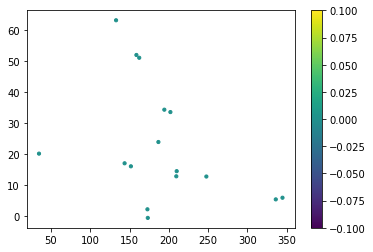

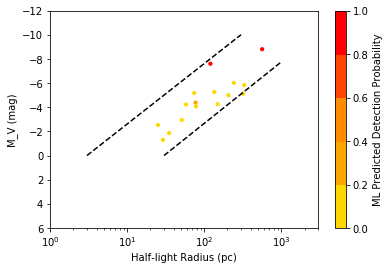

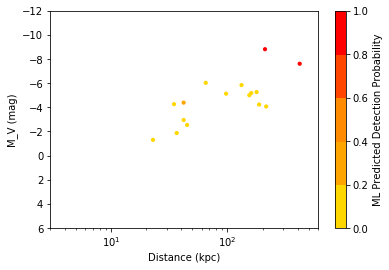

In [21]:
PS1_ssf.predict(lon=MW_ra_SDSS[MW_dec_SDSS>-25],lat=MW_dec_SDSS[MW_dec_SDSS>-25],distance=MW_r_SDSS[MW_dec_SDSS>-25],
                abs_mag=MW_Mv_SDSS[MW_dec_SDSS>-25],r_physical=MW_r12_SDSS[MW_dec_SDSS>-25])